---
title: pylbm tutorial
authors: Loic Gouarin
---

A lattice Boltzmann scheme can be defined by

- the velocities
- the conserved moments
- the transformation matrix from moments to distribution functions
- the equilibrium
- the relaxation parameters

# Define the velocities of your scheme

In [1]:
%matplotlib widget

In [2]:
import pylbm
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt

In [3]:
s = pylbm.Stencil(
    {
        'dim': 1,
        'schemes':
        [
            {
                'velocities': list(range(3)) # equivalent to D1Q3
            }
        ]
})
s

+---------------------+
| Stencil information |
+---------------------+
    - spatial dimension: 1
    - minimal velocity in each direction: [-1]
    - maximal velocity in each direction: [1]
    - information for each elementary stencil:
        stencil 0
            - number of velocities: 3
            - velocities
                (0: 0)
                (1: 1)
                (2: -1)

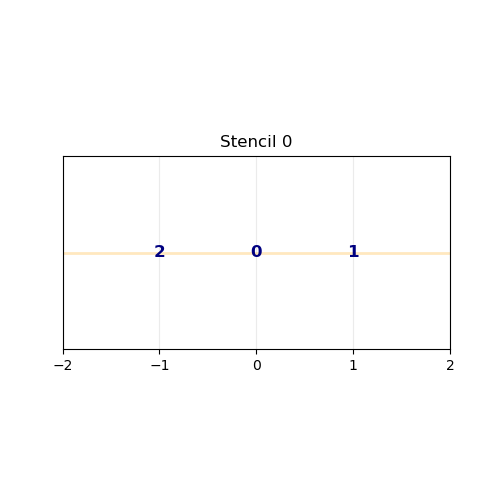

In [4]:
s.visualize()

In [5]:
dim = widgets.Dropdown(options=['1', '2', '3'], value='1',
                       description='Dimension:',
                       disabled=False)
nv = widgets.IntSlider(0, min=1, max=100, description='number of vel.')
plot = widgets.AppLayout()

def update(change):
    with plt.ioff():
        s = pylbm.Stencil({'dim': int(dim.value),
                       'schemes':[
                              {'velocities': list(range(nv.value))}
                      ]
        })
        canvas = s.visualize().fig.canvas
        canvas.header_visible = False
        canvas.footer_visible = False
        plot.center = canvas

nv.observe(update, names='value')
dim.observe(update, names='value')

update(None)
box = widgets.VBox([plot, dim, nv])

:::{important} General stencil in any dimensions
:class: dropdown
{eval}`box`
:::

You can have several lattice Boltzmann schemes for your problem.

In [6]:
s = pylbm.Stencil(
    {
        'dim': 2,
        'schemes':
        [
               {
                   'velocities': list(range(9))    # equivalent to D2Q9
               },
               {
                   'velocities': list(range(1, 5)) # equivalent to D2Q4
               }
        ]
})

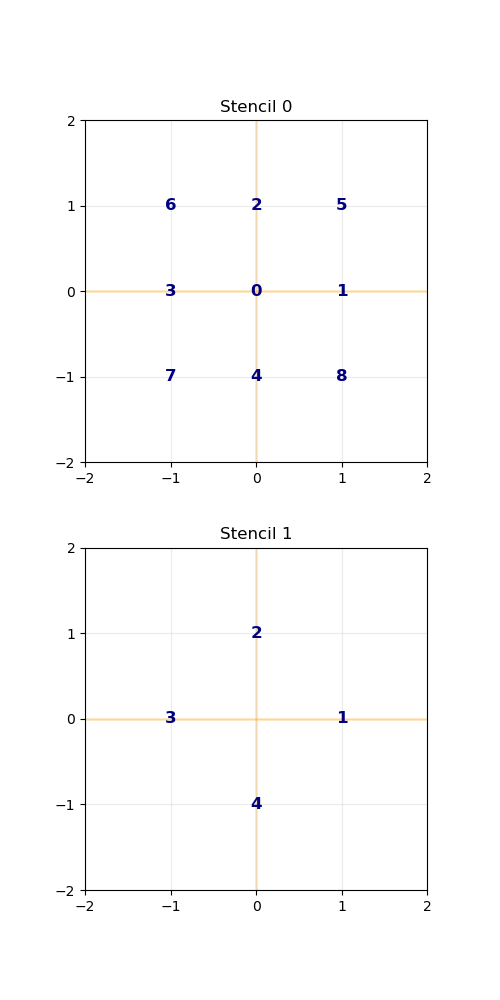

In [7]:
s.visualize()

# The advection equation

The problem reads
$$\frac{\partial}{\partial t} u + c\frac{\partial}{\partial x} u = 0, \quad t>0, \quad x\in(0, 1),$$

where $c$ is a constant scalar (typically $c=1$). We will use periodic boundary conditions for simplicity.

## Build your scheme

- Create the symbolic variables used by the scheme

In [8]:
import sympy as sp

u, la, X, eq = sp.symbols("u lambda X eq")
sigma_0 = sp.symbols("sigma_0")
s_0 = 1 / (0.5 + sigma_0) 

- Define your scheme using a Python dictionary

In [9]:
cfg = {
    "dim": 1,
    "scheme_velocity": la,
    "schemes":
    [
        {
            "velocities": [1, 2],
             "conserved_moments": u,
             "polynomials": [1, X],
             "relaxation_parameters": [0, s_0],
             "equilibrium": [u, eq],
        },
    ],
}

In [10]:
scheme = pylbm.Scheme(cfg)

In [11]:
print(scheme)

+--------------------+
| Scheme information |
+--------------------+
    - spatial dimension: 1
    - number of schemes: 1
    - number of velocities: 2
    - conserved moments: [u]
        
    +----------+
    | Scheme 0 |
    +----------+
        - velocities
            (1: 1)
            (2: -1)

        - polynomials
                    
            ⎡1⎤
            ⎢ ⎥
            ⎣X⎦

        - equilibria
                    
            ⎡u ⎤
            ⎢  ⎥
            ⎣eq⎦

        - relaxation parameters
                    
            ⎡   0    ⎤
            ⎢        ⎥
            ⎢   1    ⎥
            ⎢────────⎥
            ⎣σ₀ + 0.5⎦

    - moments matrices
                
        ⎡1  1 ⎤
        ⎢     ⎥
        ⎣λ  -λ⎦

    - inverse of moments matrices
                
        ⎡      1 ⎤
        ⎢1/2  ───⎥
        ⎢     2⋅λ⎥
        ⎢        ⎥
        ⎢     -1 ⎥
        ⎢1/2  ───⎥
        ⎣     2⋅λ⎦

    


- What kind of equation am I solving ?

In [12]:
print(pylbm.EquivalentEquation(scheme))

+----------------------+
| Equivalent Equations |
+----------------------+
    The equation is

        
    d        d       ∂ ⎛    d    ⎞
    ──(Fx) + ──(U) = ──⎜Bxx⋅──(U)⎟
    dx       dt      ∂x⎝    dx   ⎠

    where

        
    U = [u]
        
    Fx = [eq]
        
          ⎡    2   ⎤
    Bxx = ⎣Δₜ⋅λ ⋅σ₀⎦


- Fix the equilibrium to solve the advection equation

In [13]:
c = sp.symbols("c")

cfg = {
    "dim": 1,
    "scheme_velocity": la,
    "schemes":
    [
        {
            "velocities": [1, 2],
             "conserved_moments": u,
             "polynomials": [1, X],
             "relaxation_parameters": [0, s_0],
             "equilibrium": [u, c*u],
        },
    ]
}

In [14]:
print(pylbm.EquivalentEquation(pylbm.Scheme(cfg)))

+----------------------+
| Equivalent Equations |
+----------------------+
    The equation is

        
    d        d       ∂ ⎛    d    ⎞
    ──(Fx) + ──(U) = ──⎜Bxx⋅──(U)⎟
    dx       dt      ∂x⎝    dx   ⎠

    where

        
    U = [u]
        
    Fx = [c⋅u]
        
          ⎡    ⎛ 2       2   ⎞⎤
    Bxx = ⎣-Δₜ⋅⎝c ⋅σ₀ - λ ⋅σ₀⎠⎦


In [61]:
c = sp.symbols("c")
sigma_0 = sp.symbols("sigma_0")
sigma_1 = sp.symbols("sigma_1")
s_0 = 1 / (0.5 + sigma_0) 
s_1 = 1 / (0.5 + sigma_1) 
eq_0, eq_1 = sp.symbols("eq_0 eq_1")
eq_0 = sp.Function("eq_0")
eq_1 = sp.Function("eq_1")
alpha, beta = sp.symbols("alpha beta")

cfg = {
    "dim": 1,
    "scheme_velocity": la,
    "schemes":
    [
        {
            "velocities": [0, 1, 2],
             "conserved_moments": u,
             "polynomials": [1, X, X**2/2],
             "relaxation_parameters": [0, s_0, s_1],
             #"equilibrium": [u, eq_0(u), eq_1(u)],
             #"equilibrium": [u, u**2/2, eq_1(u)],
             "equilibrium": [u, u**2/2, alpha*upackage.json + beta*u**3],
        },
    ]
}

In [62]:
print(pylbm.EquivalentEquation(pylbm.Scheme(cfg)))

+----------------------+
| Equivalent Equations |
+----------------------+
    The equation is

        
    d        d       ∂ ⎛    d    ⎞
    ──(Fx) + ──(U) = ──⎜Bxx⋅──(U)⎟
    dx       dt      ∂x⎝    dx   ⎠

    where

        
    U = [u]
        
         ⎡ 2⎤
         ⎢u ⎥
    Fx = ⎢──⎥
         ⎣2 ⎦
        
          ⎡    ⎛                  2       2⎞⎤
    Bxx = ⎣-Δₜ⋅⎝-2⋅α⋅σ₀ - 6⋅β⋅σ₀⋅u  + σ₀⋅u ⎠⎦


## Run the simulation

In [15]:
def u_init(x):
    u = np.zeros_like(x)
    u[np.logical_and(x > .4, x < .6)] = 1
    return u

In [40]:
cfg = {
    "box":
    {
        "x": [0, 1], 
        "label": -1
    },
    "space_step": 0.01,
    "scheme_velocity": la,
    "schemes": 
    [
        {
            "velocities": [1, 2],
            "conserved_moments": u,
            "polynomials": [1, X],
            "relaxation_parameters": [0, s_0],
            "equilibrium": [u, c * u],
        },
    ],
    "init": {u: u_init},
    "parameters": 
    {
        la: 1, 
        c: 1.,
        sigma_0: 0.01
    },
}

In [41]:
simu = pylbm.Simulation(cfg)

In [38]:
print(simu)

+------------------------+
| Simulation information |
+------------------------+
        
    +--------------------+
    | Domain information |
    +--------------------+
        - spatial dimension: 1
        - space step: 0.01
        - with halo:
            bounds of the box: [-0.005] x [1.005]
            number of points: [102]
        - without halo:
            bounds of the box: [0.005] x [0.995]
            number of points: [100]
            
        +----------------------+
        | Geometry information |
        +----------------------+
            - spatial dimension: 1
            - bounds of the box: [0. 1.]
            - labels: [-1, -1]
        
    +--------------------+
    | Scheme information |
    +--------------------+
        - spatial dimension: 1
        - number of schemes: 1
        - number of velocities: 2
        - conserved moments: [u]
            
        +----------+
        | Scheme 0 |
        +----------+
            - velocities
                

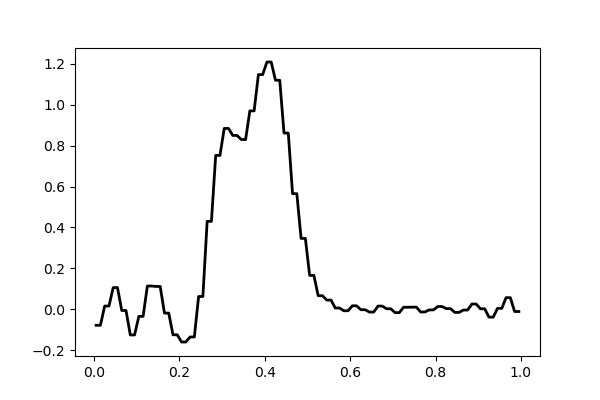

In [39]:
viewer = pylbm.viewer.matplotlib_viewer
fig = viewer.Fig()
ax = fig[0]

l1a = ax.plot(simu.domain.x, simu.m[u])[0]

def update(iframe):  
    simu.one_time_step()
    l1a.set_data(simu.domain.x, simu.m[u])
    ax.title = r"advection at $t = {0:f}$".format(simu.t)

fig.animate(update)
fig.show()

# A more complex example

In [ ]:
import numpy as np
import sympy as sp
import pylbm

X, Y, LA = sp.symbols('X, Y, LA')
rho, qx, qy, T = sp.symbols('rho, qx, qy, T')

def bc(f, m, x, y):
    m[qx] = 0.
    m[qy] = 0.
    m[T] = T0

def bc_in(f, m, x, y):
    np.random.seed(1)
    m[qx] = rhoo*uo
    m[qy] = 0.
    m[T] = T0 + (Tin - T0)*(ymax-y)*(y-.8)*100

# parameters
Tf = 100.
T0 = .5
Tin = -.5
xmin, xmax, ymin, ymax = 0., 1., 0., 1.
Ra = 2000
Pr = 0.71
Ma = 0.01
alpha = .005
dx = 1./256 # spatial step
la = 1. # velocity of the scheme
rhoo = 1.
g = 9.81
uo = 0.025

nu = np.sqrt(Pr*alpha*9.81*(T0-Tin)*(ymax-ymin)/Ra)
kappa = nu/Pr
eta = nu
snu = 1./(.5+3*nu)
seta = 1./(.5+3*eta)
sq = 8*(2-snu)/(8-snu)
se = seta
sf = [0., 0., 0., seta, se, sq, sq, snu, snu]
a = .5
skappa = 1./(.5+10*kappa/(4+a))
se = 1./(.5+np.sqrt(3)/3)
snu = se
sT = [0., skappa, skappa, se, snu]

In [ ]:
dico = {
    'box': {
        'x': [xmin, xmax],
        'y': [ymin, ymax],
        'label': [1, 2, 0, 0]
    },
    'elements': [
        pylbm.Parallelogram([xmin, ymin], [ .1, 0], [0, .8], label=0),
        pylbm.Parallelogram([xmax, ymin], [-.1, 0], [0, .8], label=0),
    ],
    'space_step': dx,
    'scheme_velocity': la,
    'schemes': [
        {
            'velocities': list(range(9)),
            'conserved_moments': [rho, qx, qy],
            'polynomials':[
                1, X, Y,
                3*(X**2+Y**2)-4,
                0.5*(9*(X**2+Y**2)**2-21*(X**2+Y**2)+8),
                3*X*(X**2+Y**2)-5*X, 3*Y*(X**2+Y**2)-5*Y,
                X**2-Y**2, X*Y
            ],
            'relaxation_parameters': sf,
            'equilibrium':[
                rho, qx, qy,
                -2*rho + 3*(qx**2+qy**2),
                rho - 3*(qx**2+qy**2),
                -qx, -qy,
                qx**2 - qy**2, qx*qy
            ],
            'source_terms': {qy: alpha*g*T},
        },
        {
            'velocities': list(range(5)),
            'conserved_moments': T,
            'polynomials': [1, X, Y, 5*(X**2+Y**2) - 4, (X**2-Y**2)],
            'equilibrium': [T, T*qx, T*qy, a*T, 0.],
            'relaxation_parameters': sT,
        },
    ],
    'init': {
        rho: 1.,
        qx: 0.,
        qy: 0.,
        T: T0,
    },
    'boundary_conditions': {
        0: {'method': {0: pylbm.bc.BouzidiBounceBack, 1: pylbm.bc.BouzidiAntiBounceBack}, 'value': bc},
        1: {'method': {0: pylbm.bc.BouzidiBounceBack, 1: pylbm.bc.BouzidiAntiBounceBack}, 'value': bc_in},
        2: {'method': {0: pylbm.bc.NeumannY, 1: pylbm.bc.NeumannY}},
    },
    'generator': "cython",
    "show_code": False
}

In [ ]:
sol = pylbm.Simulation(dico)

In [ ]:
sol.domain.visualize(view_distance=True)

In [ ]:
print(sol)

In [ ]:
# create the viewer to plot the solution
viewer = pylbm.viewer.matplotlib_viewer
fig = viewer.Fig()
ax = fig[0]
im = ax.image(sol.m[T].transpose(), cmap='RdBu', clim=[Tin, T0])
ax.title = 'solution at t = {0:f}'.format(sol.t)
ax.polygon([[xmin/dx, ymin/dx],
            [xmin/dx, (ymin+.8)/dx],
            [(xmin+.1)/dx, (ymin+.8)/dx],
            [(xmin+.1)/dx, ymin/dx]], 'k')
ax.polygon([[(xmax-.1)/dx, ymin/dx],
            [(xmax-.1)/dx, (ymin+.8)/dx],
            [xmax/dx, (ymin+.8)/dx],
            [xmax/dx, ymin/dx]], 'k')

def update(iframe):
    nrep = 64
    for i in range(nrep):
        sol.one_time_step()
    im.set_data(sol.m[T].transpose())
    ax.title = 'temperature at t = {0:f}'.format(sol.t)

fig.animate(update)
fig.show()